## Time Series Running Data

## Objective
The objective of this assignment is to identify good models for classifying time series data.  
The data is from an accelerometer sensor and there are samples of fatigued and non-fatigued running. The data has been segmented into strides and the segments (samples) are labelled F (fatigued) and NF (not fatigued). The data for two subjects A and B are available in the files  `fatigueA.csv` and  `fatigueB.csv`. This dataset is extracted from a much larger dataset described [here](https://openreview.net/pdf?id=9c0lAonDNP).  
At present, the best performing method for time-series classification is [Rocket](https://openreview.net/pdf?id=9c0lAonDNP). 
A rocket implementation is available in the [sktime tool kit](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.rocket.Rocket.html). This sktime implementation can be used in this assignment.   
Some code to get you started in available in the notebook `RunningCore`.



In [1]:
# pip install sktime

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sktime.transformations.panel.rocket import Rocket
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [3]:
# reading dataset and storing in dataframe
fatigue_df = pd.read_csv('fatigueA.csv', header = None) # sep = '\s+')
print(fatigue_df.shape)
fatigue_df.head(5)

(421, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,F,2.72,2.69,2.75,2.89,3.07,3.27,3.48,3.67,3.82,...,6.50,6.16,5.75,5.29,4.79,4.29,3.83,3.42,3.09,2.85
1,F,2.68,2.47,2.46,2.54,2.69,2.93,3.36,3.99,4.75,...,2.79,3.88,5.18,6.29,6.88,6.80,6.13,5.11,4.04,3.20
2,F,5.04,5.69,6.21,6.52,6.59,6.47,6.26,6.06,5.91,...,5.89,5.29,4.72,4.20,3.77,3.47,3.36,3.47,3.82,4.38
3,F,2.42,3.21,4.02,4.58,4.77,4.64,4.39,4.25,4.42,...,8.60,8.76,8.76,8.32,7.34,5.91,4.33,2.97,2.14,1.98
4,F,3.35,3.40,3.89,4.71,5.66,6.47,6.90,6.81,6.25,...,9.45,8.52,7.75,7.14,6.63,6.15,5.60,4.96,4.28,3.69


Text(0, 0.5, 'Accel Mag')

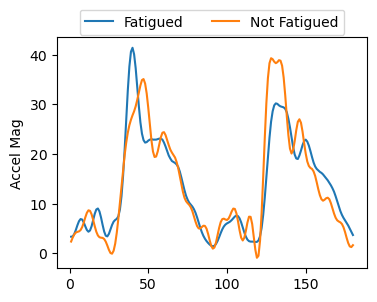

In [4]:
# plotting accel mag values for fatigued and non-fatigued running 
fatigue_df.iloc[4][1:].plot(label='Fatigued')
fatigue_df.iloc[-5][1:].plot(figsize=(4,3), label = 'Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)
plt.ylabel('Accel Mag')

In [5]:
# splitting into target and predictors
y = fatigue_df.pop(0).values
X = fatigue_df.values

### Task 1
Calculate the accuracy of a logistic regression classifier (`SGDClassifier`) on the raw time series data for subject A. 

In [6]:
# shape of target and predictors
X.shape, y.shape

((421, 180), (421,))

We see that the data has only 421 datapoints that is not enough to perform a hold-out testing. Instead we will perform 5 fold cross-validation to get accuracy of models.

In [7]:
# creating dictionary to store accuracy values
classifier_accuracy_dict = {}

In [8]:
# creating sgd classifier, calculating accuracy value after 5 fold cross validation
clf = SGDClassifier()
baseline_sgd_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
classifier_accuracy_dict['Baseline SGD Model'] = baseline_sgd_accuracy
print(f"Accuracy of the baseline logistic regression(SGD classifier) is: {round(baseline_sgd_accuracy*100,2)}%")

Accuracy of the baseline logistic regression(SGD classifier) is: 83.61%


### Task 2
The RunningCore Notebook contains code to convert the data to the `sktime` time-series format. Using this format assess the accuracy of the Rocket transformer coupled with an `SGDClassifier` classifier on the data for subject A. 


In [9]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d.shape

(421, 1, 180)

In [10]:
# making pipeline for rocket transformation followed by sgd classifier
rocket_pipeline = make_pipeline(Rocket(), SGDClassifier())
rocket_sgd_accuracy = cross_val_score(rocket_pipeline, X3d, y, cv=5, scoring='accuracy').mean()
classifier_accuracy_dict['Rocket + SGD Model'] = rocket_sgd_accuracy
print(f"Accuracy with Rocket Transformer is: {round(rocket_sgd_accuracy*100,2)}%")

Accuracy with Rocket Transformer is: 90.98%


We see that the accuracy of the SGD classifier after applying Rocket transformation increases from `83.61%` to `90.98%`.

### Task 3

In [11]:
# Normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# predicting accuracies of various classifiers
clfrs = {
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Ridge Classifier': RidgeClassifier()
}

for clf_name, clf in clfrs.items():
    accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy').mean()
    classifier_accuracy_dict[clf_name] = accuracy
    print(f"Accuracy with {clf_name} is: {round(accuracy*100,2)}%")

Accuracy with Support Vector Machine is: 84.83%
Accuracy with Random Forest is: 84.6%
Accuracy with K-Nearest Neighbors is: 86.03%
Accuracy with Ridge Classifier is: 81.73%


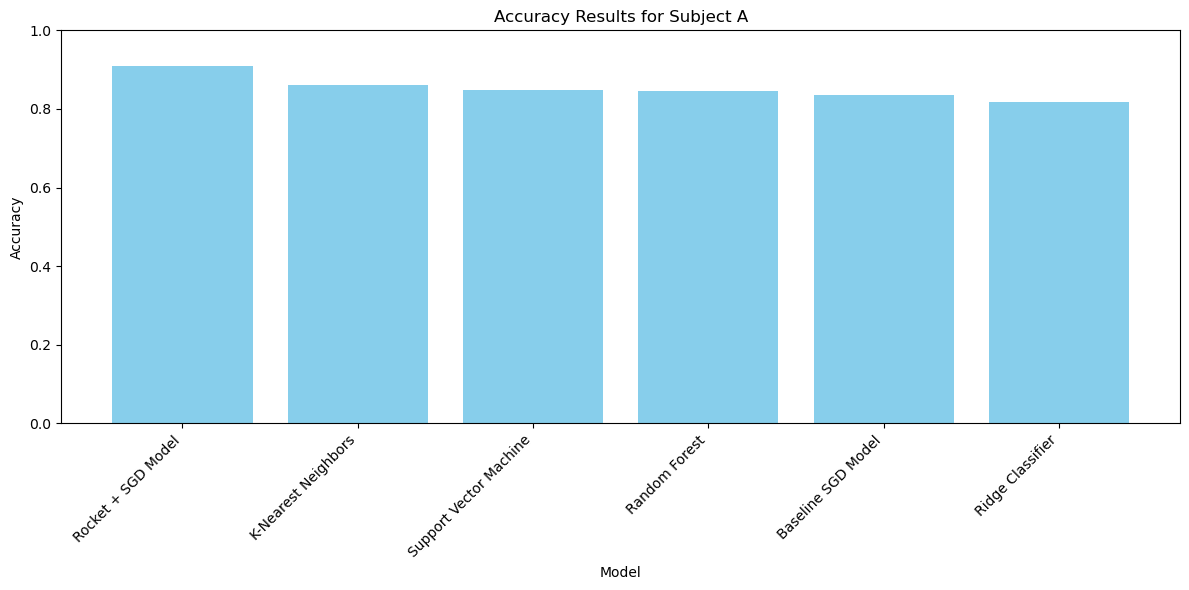

In [13]:
# plotting accuracy results for subject A
sorted_results = dict(sorted(classifier_accuracy_dict.items(), key=lambda item: item[1], reverse=True))
model_names = list(sorted_results.keys())
accuracies = list(sorted_results.values())
plt.figure(figsize=(12,6))
plt.bar(model_names, accuracies, color='skyblue')
plt.title('Accuracy Results for Subject A')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

For Subject A<br>
1. Baseline Logistic Regression (SGD Classifier) had an accuracy of 83.61%.<br>
2. Rocket Transformer improved accuracy to 90.98%.<br>
3. Support Vector Machine, Random Forest, K-Nearest Neighbors, and Ridge Classifier had accuracies ranging from 81.73% to 86.03%.

### Task 4

In [14]:
# predicting accuracy for different values for rocket kernel and different classifiers
kernels = [250, 500, 1000, 1500, 2000]
for k in kernels:
    print(f'For kernel = {k}')
    for clf_name, clf in clfrs.items():
        rocket_pipeline = make_pipeline(Rocket(), clf)
        accuracy = cross_val_score(rocket_pipeline, X3d, y, cv=5, scoring='accuracy').mean()
        name = 'Rocket with Kernel=' + str(k) + ' + ' + clf_name
        classifier_accuracy_dict[name] = accuracy
        print(f"Accuracy with {name} is: {round(accuracy*100,2)}%")

For kernel = 250
Accuracy with Rocket with Kernel=250 + Support Vector Machine is: 86.26%
Accuracy with Rocket with Kernel=250 + Random Forest is: 92.42%
Accuracy with Rocket with Kernel=250 + K-Nearest Neighbors is: 87.69%
Accuracy with Rocket with Kernel=250 + Ridge Classifier is: 92.2%
For kernel = 500
Accuracy with Rocket with Kernel=500 + Support Vector Machine is: 86.97%
Accuracy with Rocket with Kernel=500 + Random Forest is: 92.42%
Accuracy with Rocket with Kernel=500 + K-Nearest Neighbors is: 88.17%
Accuracy with Rocket with Kernel=500 + Ridge Classifier is: 93.15%
For kernel = 1000
Accuracy with Rocket with Kernel=1000 + Support Vector Machine is: 86.5%
Accuracy with Rocket with Kernel=1000 + Random Forest is: 92.66%
Accuracy with Rocket with Kernel=1000 + K-Nearest Neighbors is: 87.46%
Accuracy with Rocket with Kernel=1000 + Ridge Classifier is: 91.96%
For kernel = 1500
Accuracy with Rocket with Kernel=1500 + Support Vector Machine is: 86.26%
Accuracy with Rocket with Kernel

For Subject A:<br>
1. For Rocket with different kernels, the Ridge Classifier and Random Forest classifier consistently achieved high accuracies (91.96% to 93.15%).
2. Other classifiers, including Support Vector Machine, and K-Nearest Neighbors had accuracies ranging from 86.26% to 88.17%.
3. The highest accuracy is achieved by Rocket with Kernel=2000 + Ridge Classifer = 93.85%

### Task 5

In [15]:
# reading dataset and storing in dataframe
fatigue_df = pd.read_csv('fatigueB.csv', header = None) # sep = '\s+')
print(fatigue_df.shape)
fatigue_df.head(5)

(251, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,F,1.49,4.09,9.27,12.70,12.80,12.00,12.40,13.20,13.00,...,9.53,9.30,9.61,9.25,8.07,7.62,8.76,9.61,7.63,3.57
1,F,7.35,7.25,7.80,7.94,7.34,6.48,5.87,5.47,5.20,...,8.92,7.66,7.76,8.28,8.99,10.20,11.60,11.90,10.70,8.72
2,F,9.31,9.06,9.41,9.51,9.23,9.14,9.08,8.45,7.63,...,11.40,10.50,9.63,9.29,9.75,10.20,10.10,10.10,10.20,10.00
3,F,9.82,10.50,9.86,10.20,10.90,10.60,9.97,9.50,8.15,...,11.50,10.60,9.07,7.65,6.83,6.67,6.28,5.09,4.77,7.00
4,F,4.68,3.68,4.63,5.01,4.05,3.40,4.00,4.62,4.25,...,11.90,10.60,11.10,12.90,14.00,13.60,13.00,12.80,11.50,8.12


Text(0, 0.5, 'Accel Mag')

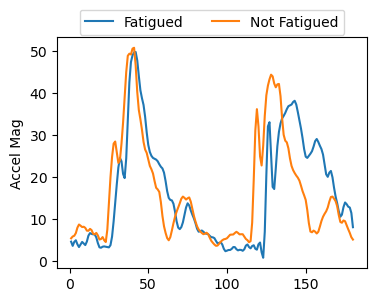

In [16]:
# plotting accel mag values for fatigued and non-fatigued running 
fatigue_df.iloc[4][1:].plot(label='Fatigued')
fatigue_df.iloc[-5][1:].plot(figsize=(4,3), label = 'Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)
plt.ylabel('Accel Mag')

In [17]:
# splitting into target and predictors
y = fatigue_df.pop(0).values
X = fatigue_df.values

In [18]:
# shape of target and predictors
X.shape, y.shape

((251, 180), (251,))

In [19]:
# creating dictionary to store accuracy values
classifier_accuracy_dict = {}

In [20]:
# creating sgd classifier, calculating accuracy value after 5 fold cross validation
clf = SGDClassifier()
baseline_sgd_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
classifier_accuracy_dict['Baseline SGD Model'] = baseline_sgd_accuracy
print(f"Accuracy of the baseline logistic regression(SGD classifier) is: {round(baseline_sgd_accuracy*100,2)}%")

Accuracy of the baseline logistic regression(SGD classifier) is: 79.3%


In [21]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d.shape

(251, 1, 180)

In [22]:
# making pipeline for rocket transformation followed by sgd classifier
rocket_pipeline = make_pipeline(Rocket(), SGDClassifier())
rocket_sgd_accuracy = cross_val_score(rocket_pipeline, X3d, y, cv=5, scoring='accuracy').mean()
classifier_accuracy_dict['Rocket + SGD Model'] = rocket_sgd_accuracy
print(f"Accuracy with Rocket Transformer is: {round(rocket_sgd_accuracy*100,2)}%")

Accuracy with Rocket Transformer is: 91.72%


In [23]:
# Normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# predicting accuracies of various classifiers
clfrs = {
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Ridge Classifier': RidgeClassifier()
}

for clf_name, clf in clfrs.items():
    accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy').mean()
    classifier_accuracy_dict[clf_name] = accuracy
    print(f"Accuracy with {clf_name} is: {round(accuracy*100,2)}%")

Accuracy with Support Vector Machine is: 84.93%
Accuracy with Random Forest is: 86.49%
Accuracy with K-Nearest Neighbors is: 84.53%
Accuracy with Ridge Classifier is: 84.09%


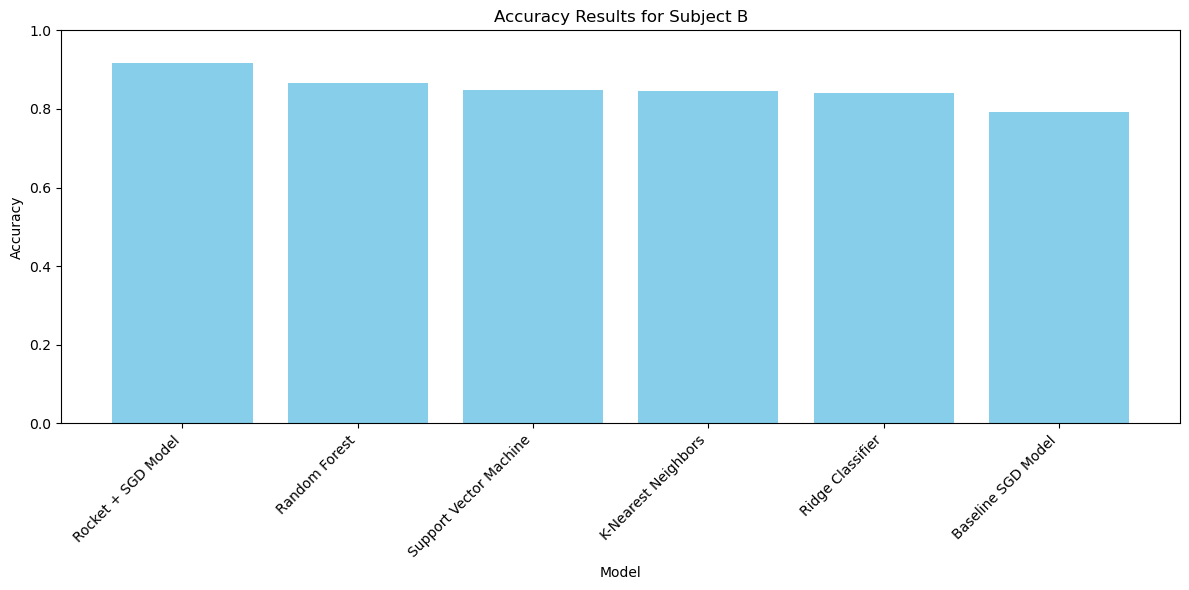

In [25]:
# plotting accuracy results for subject B
sorted_results = dict(sorted(classifier_accuracy_dict.items(), key=lambda item: item[1], reverse=True))
model_names = list(sorted_results.keys())
accuracies = list(sorted_results.values())
plt.figure(figsize=(12,6))
plt.bar(model_names, accuracies, color='skyblue')
plt.title('Accuracy Results for Subject B')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

For Subject B:
1. Baseline Logistic Regression (SGD Classifier) had an accuracy of 79.3%.<br>
2. Rocket Transformer improved accuracy to 91.72%.<br>
3. Support Vector Machine, Random Forest, K-Nearest Neighbors, and Ridge Classifier had accuracies ranging from 84.09% to 86.49%.

In [26]:
# predicting accuracy for different values for rocket kernel and different classifiers
kernels = [250, 500, 1000, 1500, 2000]
for k in kernels:
    print(f'For kernel = {k}')
    for clf_name, clf in clfrs.items():
        rocket_pipeline = make_pipeline(Rocket(), clf)
        accuracy = cross_val_score(rocket_pipeline, X3d, y, cv=5, scoring='accuracy').mean()
        name = 'Rocket with Kernel=' + str(k) + ' + ' + clf_name
        classifier_accuracy_dict[name] = accuracy
        print(f"Accuracy with {name} is: {round(accuracy*100,2)}%")

For kernel = 250
Accuracy with Rocket with Kernel=250 + Support Vector Machine is: 90.91%
Accuracy with Rocket with Kernel=250 + Random Forest is: 93.28%
Accuracy with Rocket with Kernel=250 + K-Nearest Neighbors is: 90.91%
Accuracy with Rocket with Kernel=250 + Ridge Classifier is: 95.25%
For kernel = 500
Accuracy with Rocket with Kernel=500 + Support Vector Machine is: 90.91%
Accuracy with Rocket with Kernel=500 + Random Forest is: 90.89%
Accuracy with Rocket with Kernel=500 + K-Nearest Neighbors is: 91.32%
Accuracy with Rocket with Kernel=500 + Ridge Classifier is: 95.65%
For kernel = 1000
Accuracy with Rocket with Kernel=1000 + Support Vector Machine is: 90.91%
Accuracy with Rocket with Kernel=1000 + Random Forest is: 91.29%
Accuracy with Rocket with Kernel=1000 + K-Nearest Neighbors is: 90.92%
Accuracy with Rocket with Kernel=1000 + Ridge Classifier is: 96.45%
For kernel = 1500
Accuracy with Rocket with Kernel=1500 + Support Vector Machine is: 91.31%
Accuracy with Rocket with Kern

### Comparing accuracy for different kernel values for Rocket
For Subject B:<br>
1. Similar to Subject A, the Ridge classifier achieved high accuracies (95.25% to 96.45%) with Rocket.
2. Other classifiers, such as Support Vector Machine, Random Forest, and K-Nearest Neighbors, also showed good performance, but Ridge Classifier consistently performed well across all kernel values.

### Summing up
1. For both subjects, the Rocket Transformer significantly improved accuracy compared to the baseline Logistic Regression (SGD Classifier).<br>
2. Ridge Classifier consistently demonstrated high accuracy and robust performance with Rocket for both subjects.<br>
3. The performance of other classifiers varied between subjects A and B, indicating that the effectiveness of models may depend on the individual characteristics of the subjects.


### Overall Conclusion:
1. The Rocket Transformer appears effective in enhancing classification performance for both subjects.
2. Ridge Classifier consistently demonstrated high accuracy and robust performance with Rocket.
3. Subject-specific variations suggest that model effectiveness may depend on individual subject characteristics.
4. These conclusions align with the observations from Task 3 and Task 4 for both subjects A and B.